---
## 5. 사계절 길이 예측

#### 5-0. 라이브러리 호출

In [69]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
import matplotlib.pyplot as plt

#### 5-1. CO2 배경대기농도 & 사계절길이 데이터 호출

In [70]:
temp_co2 = pd.read_csv('./DB/co2_mm_mlo.csv')
co2 = temp_co2.groupby('year')['average'].mean().reset_index()
co2.rename(columns={'average':'CO2(ppm)'}, inplace=True)

In [71]:
season = pd.read_csv('./DB/4-season_2.csv')
season = season.drop('Unnamed: 0', axis=1).reset_index()
season.drop('index', axis=1, inplace=True)

In [72]:
merged_data = pd.merge(co2, season, on='year')
merged_data

,year,CO2(ppm),spring,summer,fall,winter
0,1959,315.980833,89,99,51,126
1,1960,316.910000,99,108,60,99
2,1961,317.644167,81,104,78,102
3,1962,318.454167,70,101,60,134
4,1963,318.992500,82,108,66,109
...,...,...,...,...,...,...
60,2019,411.654167,97,125,43,100
61,2020,414.238333,99,114,62,91
62,2021,416.450833,100,127,47,91
63,2022,418.564167,87,115,65,98


In [73]:
co2_2050 = pd.read_csv('./DB/2024-2050_co2.csv')

#### 5-2. SARIMAX 예측

In [74]:
def find_best_sarimax_params(data, exog, season_name):
    print('------------------------------')
    
    # 가능한 파라미터 범위 설정
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
    
    best_aic = float('inf')
    best_params = None
    best_seasonal_params = None
    
    # 파라미터 조합을 시도하면서 가장 낮은 AIC 값을 찾음
    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                model = SARIMAX(data,
                              exog=exog,
                              order=param,
                              seasonal_order=seasonal_param,
                              enforce_stationarity=False,
                              enforce_invertibility=False)
                results = model.fit(disp=False)
                
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = param
                    best_seasonal_params = seasonal_param
                    
            except Exception:
                continue
    
    print(f'Best Parameters for "{season_name}":')
    print(f'SARIMAX{best_params}x{best_seasonal_params}')
    
    return best_params, best_seasonal_params

def evaluate_predictions(actual, predicted):
    # 이상치가 많고 각 오차의 크기를 고르게 평가하고 싶다면 → MAE가 적합
    mae = np.mean(np.abs(actual - predicted))
    print(f'MAE: {mae:.2f}')
    
    return mae


# 메인 예측 프로세스
def seasonal_prediction_process(train_data, test_data, train_exog, test_exog):
    warnings.filterwarnings('ignore')
    
    season_predictions = pd.DataFrame(index=test_data.index, columns=['spring', 'summer', 'fall', 'winter'])
    evaluation_metrics = {}
    
    for season in ['spring', 'summer', 'fall', 'winter']:
        # 최적의 파라미터 찾기
        best_params, best_seasonal_params = find_best_sarimax_params(
            train_data[season], 
            train_exog,
            season
        )
        
        # 최적의 파라미터로 모델 학습
        model = SARIMAX(
            train_data[season],
            exog=train_exog,
            order=best_params,
            seasonal_order=best_seasonal_params
        )
        fitted_model = model.fit(disp=False)
        
        # 예측 수행
        predictions = fitted_model.forecast(
            steps=len(test_exog),
            exog=test_exog
        )
        season_predictions[season] = predictions
        
        # 예측 결과 평가
        mae = evaluate_predictions(test_data[season], predictions)
        evaluation_metrics[season] = {'MAE': mae}
    
    return season_predictions, evaluation_metrics

In [75]:
# 학습 및 예측 데이터 분리
train_data = merged_data[merged_data['year'] <= 2003]
test_data = merged_data[(merged_data['year'] >= 2004) & (merged_data['year'] <= 2023)]
train_exog = co2[co2['year'] <= 2003]
test_exog = co2[co2['year'] >= 2004]

season_predictions, evaluation_metrics = seasonal_prediction_process(
    train_data, test_data, train_exog, test_exog
)

------------------------------
Best Parameters for "spring":
SARIMAX(0, 1, 1)x(0, 1, 1, 12)
MAE: 10.51
------------------------------
Best Parameters for "summer":
SARIMAX(0, 0, 1)x(0, 1, 1, 12)
MAE: 6.37
------------------------------
Best Parameters for "fall":
SARIMAX(0, 1, 1)x(1, 1, 1, 12)
MAE: 12.42
------------------------------
Best Parameters for "winter":
SARIMAX(0, 1, 1)x(1, 1, 1, 12)
MAE: 21.49


In [76]:
exog_2024_2050 = pd.read_csv('./DB/2024-2050_co2.csv')

season_predictions = pd.DataFrame(index=range(2024, 2051), columns=['spring', 'summer', 'fall', 'winter'])

param = {
    'spring': [(0, 1, 1), (0, 1, 1, 12)],
    'summer': [(0, 0, 1), (0, 1, 1, 12)],
    'fall': [(0, 1, 1), (1, 1, 1, 12)],
    'winter': [(0, 1, 1), (1, 1, 1, 12)]
}

for season in ['spring', 'summer', 'fall', 'winter']:
    model = SARIMAX(merged_data[season], exog=merged_data['CO2(ppm)'], order=param[season][0], seasonal_order=param[season][1])
    fitted_model = model.fit(disp=False)
    
    predictions = fitted_model.predict(start=len(merged_data), end=len(merged_data) + len(exog_2024_2050) - 1, exog=exog_2024_2050['average'])
    season_predictions[season] = predictions.values

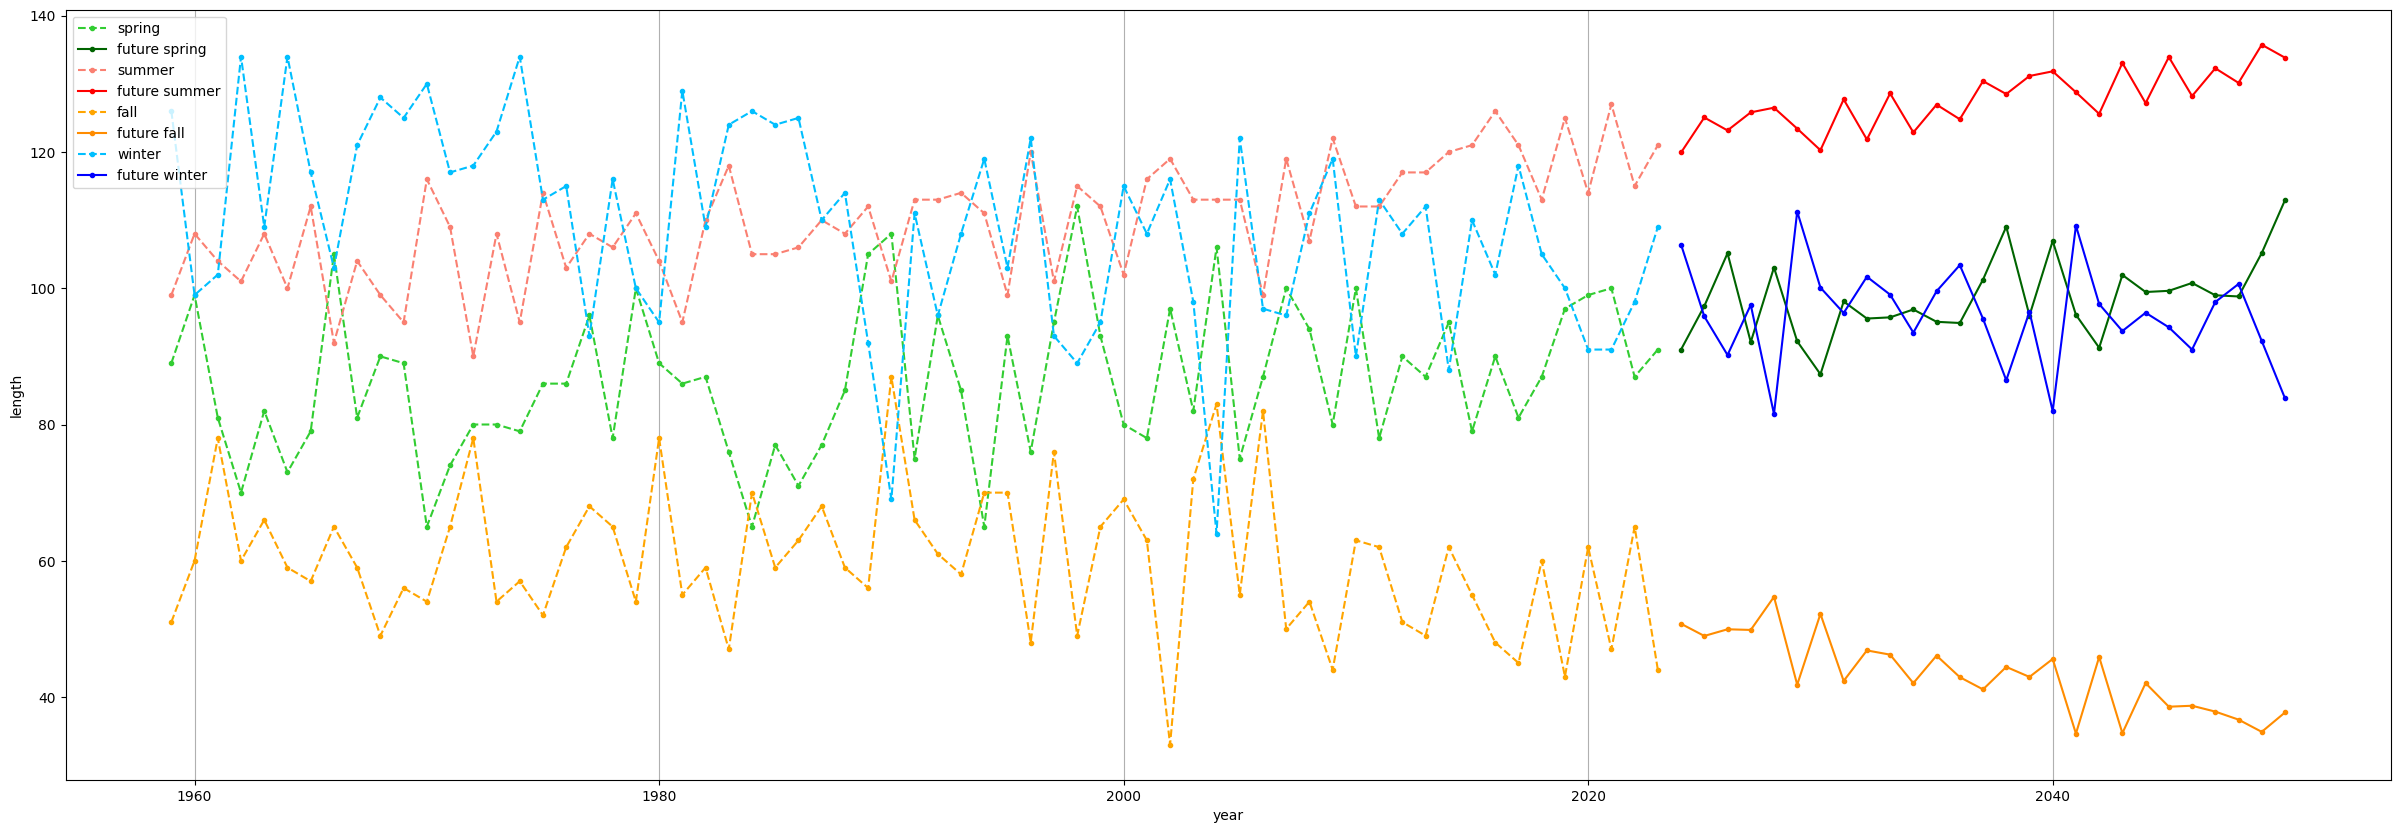

In [77]:
plt.figure(figsize=(30,10))

# 봄
plt.plot(merged_data['year'], merged_data['spring'], color='limegreen', marker='.', ls='--', label='spring')
plt.plot(season_predictions.index, season_predictions['spring'], color='darkgreen', marker='.', label='future spring')

# 여름
plt.plot(merged_data['year'], merged_data['summer'], color='salmon', marker='.', ls='--', label='summer')
plt.plot(season_predictions.index, season_predictions['summer'], color='red', marker='.', label='future summer')

# 가을
plt.plot(merged_data['year'], merged_data['fall'], color='orange', marker='.', ls='--', label='fall')
plt.plot(season_predictions.index, season_predictions['fall'], color='darkorange', marker='.', label='future fall')

# 겨울
plt.plot(merged_data['year'], merged_data['winter'], color='deepskyblue', marker='.', ls='--', label='winter')
plt.plot(season_predictions.index, season_predictions['winter'], color='blue', marker='.', label='future winter')

plt.grid(axis='x'); plt.xlabel('year'); plt.ylabel('length')
plt.legend()
plt.show()

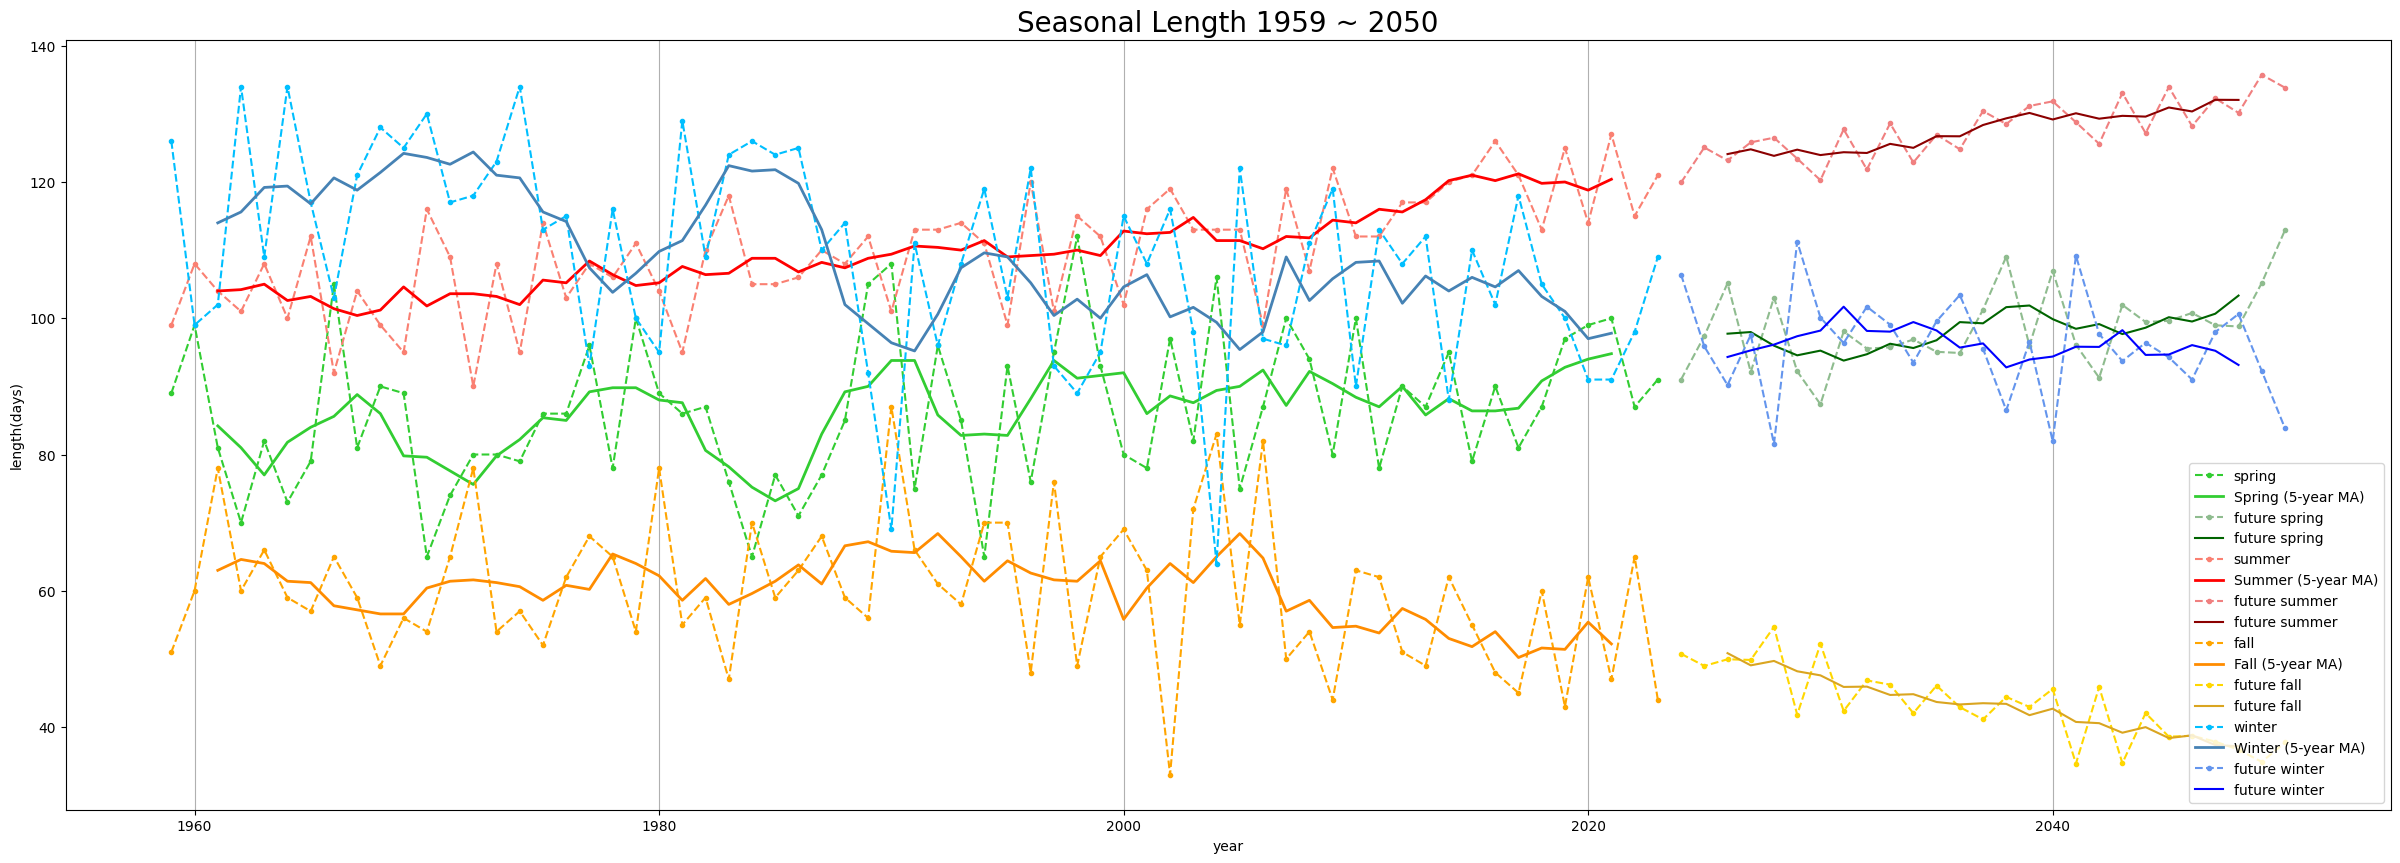

In [78]:
plt.figure(figsize=(30,10))

spring_ma = merged_data['spring'].rolling(window=5, center=True).mean()
summer_ma = merged_data['summer'].rolling(window=5, center=True).mean()
fall_ma = merged_data['fall'].rolling(window=5, center=True).mean()
winter_ma = merged_data['winter'].rolling(window=5, center=True).mean()

spring_ma_pred = season_predictions['spring'].rolling(window=5, center=True).mean()
summer_ma_pred = season_predictions['summer'].rolling(window=5, center=True).mean()
fall_ma_pred = season_predictions['fall'].rolling(window=5, center=True).mean()
winter_ma_pred = season_predictions['winter'].rolling(window=5, center=True).mean()

# 봄
plt.plot(merged_data['year'], merged_data['spring'], color='limegreen', marker='.', ls='--', label='spring')
plt.plot(merged_data['year'], spring_ma, label='Spring (5-year MA)', color='limegreen', linewidth=2)
plt.plot(season_predictions.index, season_predictions['spring'], color='darkseagreen', ls='--', marker='.', label='future spring')
plt.plot(season_predictions.index, spring_ma_pred, color='darkgreen', label='future spring')

# 여름
plt.plot(merged_data['year'], merged_data['summer'], color='salmon', marker='.', ls='--', label='summer')
plt.plot(merged_data['year'], summer_ma, label='Summer (5-year MA)', color='red', linewidth=2)
plt.plot(season_predictions.index, season_predictions['summer'], color='lightcoral', ls='--', marker='.', label='future summer')
plt.plot(season_predictions.index, summer_ma_pred, color='darkred', label='future summer')

# 가을
plt.plot(merged_data['year'], merged_data['fall'], color='orange', marker='.', ls='--', label='fall')
plt.plot(merged_data['year'], fall_ma, label='Fall (5-year MA)', color='darkorange', linewidth=2)
plt.plot(season_predictions.index, season_predictions['fall'], color='gold', marker='.', ls='--', label='future fall')
plt.plot(season_predictions.index, fall_ma_pred, color='goldenrod', label='future fall')

# 겨울
plt.plot(merged_data['year'], merged_data['winter'], color='deepskyblue', marker='.', ls='--', label='winter')
plt.plot(merged_data['year'], winter_ma, label='Winter (5-year MA)', color='steelblue', linewidth=2)
plt.plot(season_predictions.index, season_predictions['winter'], color='cornflowerblue', ls='--', marker='.', label='future winter')
plt.plot(season_predictions.index, winter_ma_pred, color='blue', label='future winter')

plt.title('Seasonal Length 1959 ~ 2050', fontsize=20)
plt.grid(axis='x'); plt.xlabel('year'); plt.ylabel('length(days)')
plt.legend()
plt.show()